# Stock Price Prediction and Analysis

**Author:** Aniket Pathare | **Student ID:** 20050492

Hey there! In this notebook, we're diving into predicting stock prices using some cool machine learning techniques. I've picked up the dataset at realtime & the dataset maintains compliance with the ask of choosing a real word dataset Here's what we'll cover:

1. **Classification Tasks**
   - Exploring different predictive models.
   - Training these models with various data splits.
   - Boosting performance with ensemble methods.
   - Picking the best classifier out of the bunch.

2. **Regression Analysis**
   - Using ensemble methods to predict continuous values like stock prices.

3. **Feature Extraction and Evaluation**
   - Cutting down on data complexity with PCA (Principal Component Analysis).
   - Comparing how models perform with and without PCA to see what's best.

# Question 1:
#Use a real-world dataset (i.e. relational, text, image, video, voice files), prepare the dataset for modelling, consider one categorical variable in the dataset, and apply three classification task

Let's get started and see how we can make some stock predictions!


In [60]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    StackingClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor
)
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import mplfinance as mpf
import warnings

from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')


## Visualization Utilities

To facilitate consistent and informative visualizations throughout the analysis, we define a `Visualization` class containing static methods for various plots.


In [61]:
# Visualization Functions

def plot_boxplot(results, title, ylabel, xlabel):
    # Restructure the results dictionary into a long-format DataFrame
    data = []
    for method, scores in results.items():
        for score in scores:
            data.append({"Method": method, "Accuracy": score})
    results_df = pd.DataFrame(data)

    # Plot the boxplot
    plt.figure(figsize=(12, 8))
    sns.boxplot(x="Method", y="Accuracy", data=results_df)
    sns.swarmplot(x="Method", y="Accuracy", data=results_df, color=".25", alpha=0.7)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()


def plot_regression_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')
    plt.title(title)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

def plot_feature_importance(model, feature_names, title):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(12, 8))
        sns.barplot(x=[feature_names[i] for i in indices], y=importances[indices])
        plt.title(title)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.xticks(rotation=90)
        plt.show()
    else:
        print(f"The model {type(model).__name__} does not have feature_importances_ attribute.")

def plot_pca_explained_variance(pca, title="PCA Explained Variance"):
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance (%)')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_pca_loadings(pca, feature_names, n_components=2, title="PCA Loadings"):
    plt.figure(figsize=(12, 8))
    components = pca.components_[:n_components]
    for i in range(n_components):
        plt.subplot(1, n_components, i + 1)
        sns.barplot(x=feature_names, y=components[i])
        plt.title(f'PC{i+1} Loadings')
        plt.xlabel('Features')
        plt.ylabel('Loading')
        plt.xticks(rotation=90)
        plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.05)
    plt.show()

def plot_correlation_heatmap(data, title="Feature Correlation Heatmap"):
    plt.figure(figsize=(14, 12))
    sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(title)
    plt.show()

def plot_confusion_matrix_heatmap(conf_matrix, classes, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

def plot_roc_curve(model, X_test, y_test, title="ROC Curve"):
    from sklearn.metrics import roc_curve, auc
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, title="Precision-Recall Curve"):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    y_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    avg_precision = average_precision_score(y_test, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Average Precision = {avg_precision:.2f}')
    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.show()

def plot_time_series(y_true, y_pred, dates, title="Actual vs Predicted Close Prices"):
    plt.figure(figsize=(14, 7))
    plt.plot(dates, y_true, label='Actual Close Prices', color='blue')
    plt.plot(dates, y_pred, label='Predicted Close Prices', color='orange', alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(title)
    plt.legend()
    plt.show()


# Functional Forms of Predictive Models

Before diving into model training, it's essential to understand the underlying mathematical formulations of the classification algorithms we'll be using: **Support Vector Machine (SVM)**, **Logistic Regression**, and **K-Nearest Neighbors (KNN)** I evaluated the other classification models as well but these three outperformed.

# Question 1 , Subquestion a)	Provide the functional form of the predictive model for each algorithm.


In [62]:
# Functional Forms of Classification Models

functional_forms = {
    # Support Vector Machine (SVM):
    # Functional Form: f(x) = sign(w·x + b)
    # - SVM is a classification algorithm that finds the optimal hyperplane to separate classes.
    # - The hyperplane is chosen to maximize the margin between the nearest points of different classes (support vectors).
    # - The decision rule assigns a class based on the sign of w·x + b:
    #   * +1 for one class
    #   * -1 for the other class.
    # - It can handle both linear and non-linear decision boundaries using kernels.
    "Support Vector Machine": "f(x) = sign(w·x + b), where w is the weight vector and b is the bias.",

    # Logistic Regression:
    # Functional Form: P(y=1|x) = 1 / (1 + exp(-(w·x + b)))
    # - Logistic regression models the probability of a binary outcome using the sigmoid function.
    # - It predicts the probability P(y=1|x), which can be thresholded to classify the input.
    # - Parameters (w, b) are optimized using maximum likelihood estimation.
    # - Logistic regression is interpretable and works best with linear decision boundaries.
    "Logistic Regression": "P(y=1|x) = 1 / (1 + exp(-(w·x + b)))",

    # K-Nearest Neighbors (KNN):
    # Functional Form: f(x) = mode(y_i) for the k nearest neighbors of x in the training set.
    # - KNN is a non-parametric algorithm that predicts based on the closest training samples in the feature space.
    # - It uses a distance metric (e.g., Euclidean) to find the k nearest neighbors.
    # - For classification, KNN assigns the most common class (mode) among the neighbors.
    # - For regression, it predicts the average value of the target variable for the neighbors.
    "K-Nearest Neighbors": "f(x) = mode(y_i) for the k nearest neighbors of x in the training set."
}

print("\nFunctional Forms of Predictive Models:")
for model, form in functional_forms.items():
    print(f"{model}: {form}\n")



Functional Forms of Predictive Models:
Support Vector Machine: f(x) = sign(w·x + b), where w is the weight vector and b is the bias.

Logistic Regression: P(y=1|x) = 1 / (1 + exp(-(w·x + b)))

K-Nearest Neighbors: f(x) = mode(y_i) for the k nearest neighbors of x in the training set.



# Fetching and Exploring Data

We fetch historical stock data for **TATAMOTORS.NS** from January 1, 2015, to January 1, 2023,

1. **Setting Up:**
   - **Stock Symbol:** We're focusing on `TATAMOTORS.NS` user has the freedom to enter any stock they desire and time range Below is the timeframe i've chosen.
   - **Date Range:** From January 1, 2015, to January 1, 2023.

2. **Downloading the Data:**
   - Using `yfinance` to pull in the historical real word stock data.
   - If the data has multi-level columns, we flatten them for simplicity.
   - Clean up the column names by removing any extra tags or symbols.

3. **Creating the Target:**
   - **Price Change (`Price_Change`):** The difference in closing price from the previous day.
   - **Category (`Category`):**  for leveraging during classification tasks
     - `1` if `Price_Change` is positive (price went up).
     - `0` if `Price_Change` is negative or zero (price went down or stayed the same).
   - We drop any rows with missing values/NaN that resulted from these calculations.

4. **Exploring the Data:**
   - **Columns:** Lists all the columns in our dataset.
   - **Head & Tail:** Shows the first and last few rows to give a snapshot of the data.
   - **Info:** Provides details about data types and missing values.
   - **Descriptive Stats:** Gives a statistical summary of the numerical columns.
   - **Shape & Missing Values:** Tells us the size of the dataset and checks for any remaining missing data.

5. **Visualizing Closing Prices:**
   - Plots the closing prices over time to visualize trends, volatility, and overall performance of the stock.



[*********************100%***********************]  1 of 1 completed

-------------------------------Display Columns inside the dataset--------------------------
Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Price_Change',
       'Category'],
      dtype='object')
-------------------------------Head of the dataset:----------------------------------------
             Adj Close       Close        High         Low        Open  \
Date                                                                     
2015-01-02  503.038666  506.368683  511.909271  491.973083  491.973083   
2015-01-05  514.833313  518.241333  520.417969  501.322815  504.686737   
2015-01-06  492.816742  496.079071  508.891632  493.951874  508.891632   
2015-01-07  485.395966  488.609192  495.089661  484.008514  489.746979   
2015-01-08  503.235260  506.566559  509.336853  495.683289  498.651459   

             Volume  Price_Change  Category  
Date                                         
2015-01-02  4193093     13.208313         1  
2015-01-05  6758676     11.872650      

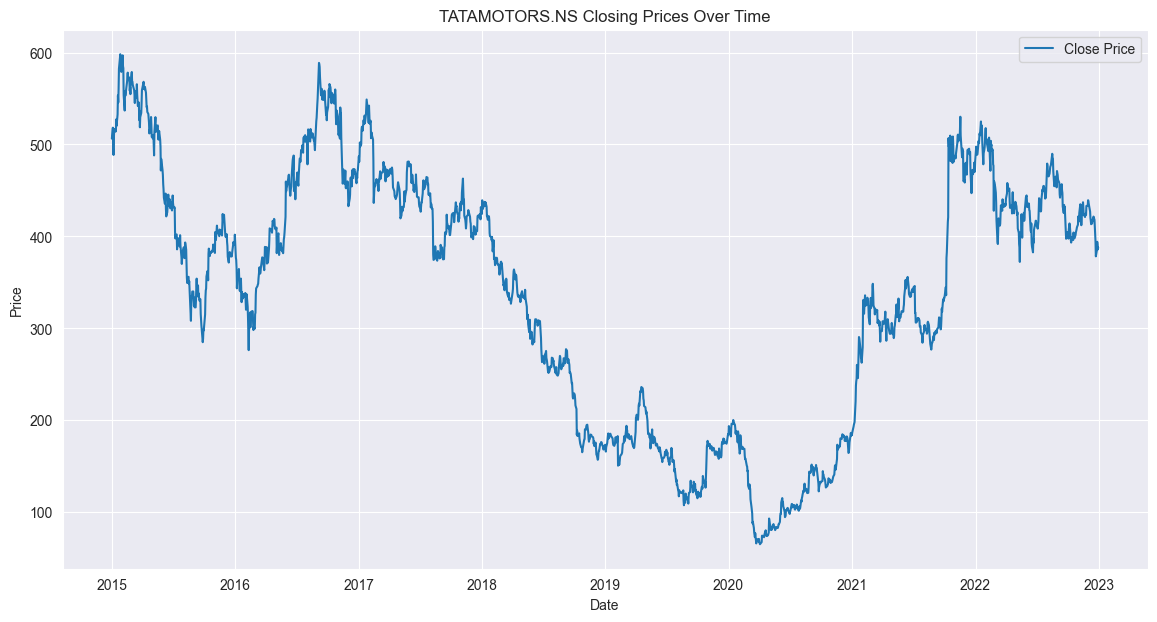

In [63]:
# Fetching and Exploring Data

# Define stock symbol and date range
stock_symbol = 'TATAMOTORS.NS'
start_date = '2015-01-01'
end_date = '2023-01-01'

# Fetch data using yfinance
data = yf.download(stock_symbol, start=start_date, end=end_date)

# Flatten the multi-index columns if present
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() if col[1] else col[0] for col in data.columns.values]

# Simplify column names by removing the ticker suffix part of data cleaning prior to modelling and training.
ticker_suffix = f"_{stock_symbol}"
rename_dict = {col: col.replace(ticker_suffix, "") for col in data.columns if ticker_suffix in col}
data.rename(columns=rename_dict, inplace=True)

# Create classification target choosing "CATEGORY"
data['Price_Change'] = data['Close'].diff()
data['Category'] = (data['Price_Change'] > 0).astype(int)

# Drop NaN values
data = data.dropna()

# Display data exploration information
print("-------------------------------Display Columns inside the dataset--------------------------")
print(data.columns)
print("-------------------------------Head of the dataset:----------------------------------------")
print(data.head())
print("-------------------------------Tail of the dataset:----------------------------------------")
print(data.tail())
print("-------------------------------Dataset Information:----------------------------------------")
print(data.info())
print("-------------------------------Descriptive Statistics:-------------------------------------")
print(data.describe())
print("-------------------------------Dataset Shape:----------------------------------------------")
print(data.shape)
print("-------------------------------Missing Values:---------------------------------------------")
print(data.isnull().sum())
print("-------------------------------------------------------------------------------------------")

# Visualization: Plotting Closing Prices Over Time
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.title(f"{stock_symbol} Closing Prices Over Time")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# Feature Engineering

To enhance the predictive capacity of our models,perform feature engineering by creating additional derived features such as volatility, moving averages, RSI, MACD, and more. This step enriches the dataset with informative variables that can improve model performance.Feature engineering was essential cause the default Columns pulled from Yahoo Finance were limited and it was really essential to provide the model with multiple data.


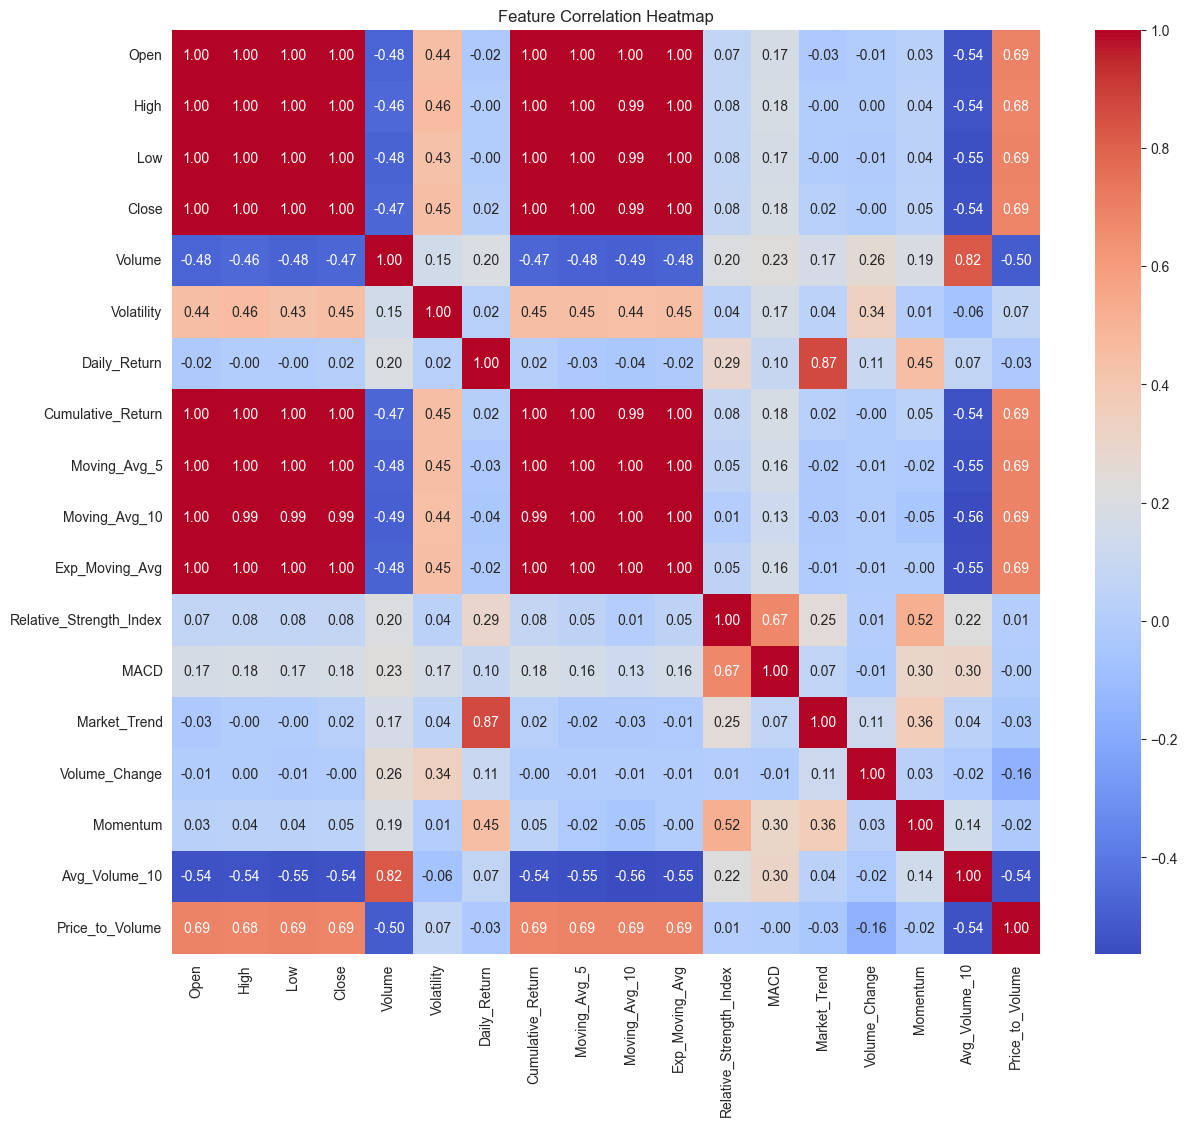

In [64]:
# Feature Engineering

# Calculate Volatility
data['Volatility'] = data['High'] - data['Low']

# Calculate Daily Return
data['Daily_Return'] = data['Close'].pct_change()

# Calculate Cumulative Return
data['Cumulative_Return'] = (1 + data['Daily_Return']).cumprod()

# Moving Averages
data['Moving_Avg_5'] = data['Close'].rolling(window=5).mean()
data['Moving_Avg_10'] = data['Close'].rolling(window=10).mean()

# Exponential Moving Average
data['Exp_Moving_Avg'] = data['Close'].ewm(span=5, adjust=False).mean()

# Relative Strength Index (RSI)
def calculate_rsi(prices, window):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['Relative_Strength_Index'] = calculate_rsi(data['Close'], window=14)

# Moving Average Convergence Divergence (MACD)
def calculate_macd(prices):
    ema_12 = prices.ewm(span=12, adjust=False).mean()
    ema_26 = prices.ewm(span=26, adjust=False).mean()
    return ema_12 - ema_26

data['MACD'] = calculate_macd(data['Close'])

# Market Trend
data['Market_Trend'] = data['Close'] / data['Open'] - 1

# Volume Change
data['Volume_Change'] = data['Volume'].pct_change()

# Momentum
data['Momentum'] = data['Close'] - data['Close'].shift(4)

# Average Volume over 10 days
data['Avg_Volume_10'] = data['Volume'].rolling(window=10).mean()

# Price to Volume Ratio
data['Price_to_Volume'] = data['Close'] / data['Volume']

# Drop NaN values resulted from feature engineering additional columns
data = data.dropna()

# Update features list post feature engineering steps
features = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'Volatility', 'Daily_Return', 'Cumulative_Return',
    'Moving_Avg_5', 'Moving_Avg_10', 'Exp_Moving_Avg', 'Relative_Strength_Index', 'MACD', 'Market_Trend',
    'Volume_Change', 'Momentum', 'Avg_Volume_10', 'Price_to_Volume'
]

# Visualization: Correlation Heatmap
plot_correlation_heatmap(data[features], title="Feature Correlation Heatmap")


# Data Preparation

Preparing the dataset for machine learning involves several steps:

1. **Splitting the Data:**
   - **Train-Test Split:** We'll split our data into training and testing sets with an 80-20 split. This helps us train our models on one portion and test their performance on unseen data.

2. **Removing Outliers:**
   - **Why:** Considering this as a pre-condition step cause Outliers can skew our models and lead to poor performance.
   - **How:** We'll use the Z-score method to identify and remove extreme values from the training set.

3. **Scaling the Features:**
   - **Why:** Scaling ensures that all features contribute equally to the model's learning process.
   - **How:** Applied `MinMaxScaler` to scale all features between 0 and 1.

4. **Handling Class Imbalance with SMOTE:**
   - **Why:** If one class is overrepresented,  models might get biased wanted to ensure both class are represented equally.
   - **How:** We'll use SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes by generating synthetic samples for the minority class.

Additionally, visualizing the distribution of classes after applying SMOTE.


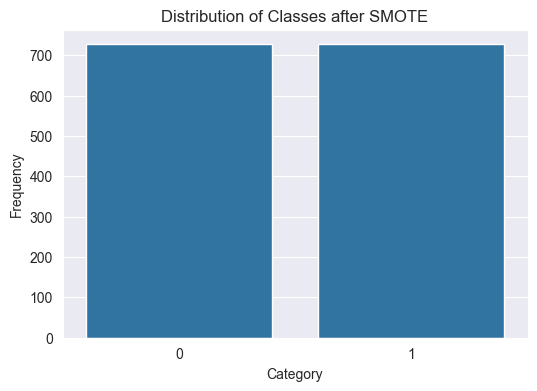

In [65]:
# Data Preparation

# Define features and target
X = data[features].values
y = data['Category'].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=None
)

# Outlier Removal using Z-score
from scipy import stats

z_scores = np.abs(stats.zscore(X_train))
threshold = 3
outliers = (z_scores < threshold).all(axis=1)
X_train_no_outliers = X_train[outliers]
y_train_no_outliers = y_train[outliers]

# Feature Scaling using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_no_outliers)
X_test_scaled = scaler.transform(X_test)

# Handling Class Imbalance with SMOTE
smote = SMOTE(random_state=None)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_no_outliers)

# Visualization: Distribution of Classes after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_balanced)
plt.title('Distribution of Classes after SMOTE')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()


# Training and Evaluating Classification Models

 Train three classification models:

1. **Support Vector Machine (SVM)**
2. **Logistic Regression**
3. **K-Nearest Neighbors (KNN)**

For each model, evaluated performance using accuracy, classification reports, and confusion matrices.I tried comparing with the performance with other models also but it turns out SVM,LR,KNN outperformed others.


In [66]:
# Model Training and Evaluation Function

def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    # Initialize classifiers
    models = {
        "Support Vector Machine": SVC(probability=True),
        "Logistic Regression": LogisticRegression(),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
    }
    results = []

    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Evaluation Metrics
        accuracy = accuracy_score(y_test, predictions)
        class_report = classification_report(y_test, predictions, output_dict=True)
        conf_matrix = confusion_matrix(y_test, predictions)

        # Print Metrics
        print(f"-------------------------------- {model_name} ----------------------------------")
        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(pd.DataFrame(class_report).transpose())
        print("Confusion Matrix:")
        print(conf_matrix)
        print("\n")

        # Visualizations
        plot_confusion_matrix_heatmap(
            conf_matrix,
            classes=['Down', 'Up'],
            title=f"{model_name} - Confusion Matrix"
        )

        #plot_roc_curve(model, X_test, y_test, title=f"{model_name} - ROC Curve")
        #plot_precision_recall_curve(model, X_test, y_test, title=f"{model_name} - Precision-Recall Curve")

        # Append results
        results.append({
            "Model": model_name,
            "Accuracy": accuracy,
            "Confusion Matrix": conf_matrix,
            "Classification Report": class_report
        })

    return results


-------------------------------- Support Vector Machine ----------------------------------
Accuracy: 0.9466
Classification Report:
              precision    recall  f1-score     support
0              0.983333  0.907692  0.944000  195.000000
1              0.915493  0.984848  0.948905  198.000000
accuracy       0.946565  0.946565  0.946565    0.946565
macro avg      0.949413  0.946270  0.946453  393.000000
weighted avg   0.949154  0.946565  0.946471  393.000000
Confusion Matrix:
[[177  18]
 [  3 195]]




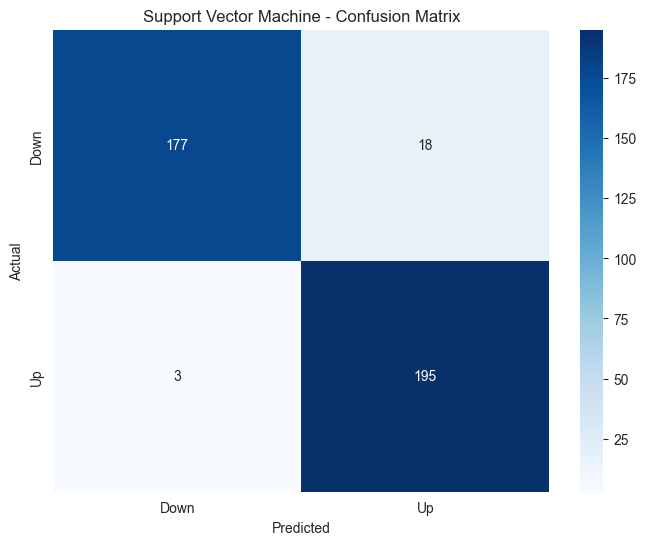

-------------------------------- Logistic Regression ----------------------------------
Accuracy: 0.9466
Classification Report:
              precision    recall  f1-score     support
0              0.957895  0.933333  0.945455  195.000000
1              0.935961  0.959596  0.947631  198.000000
accuracy       0.946565  0.946565  0.946565    0.946565
macro avg      0.946928  0.946465  0.946543  393.000000
weighted avg   0.946844  0.946565  0.946551  393.000000
Confusion Matrix:
[[182  13]
 [  8 190]]




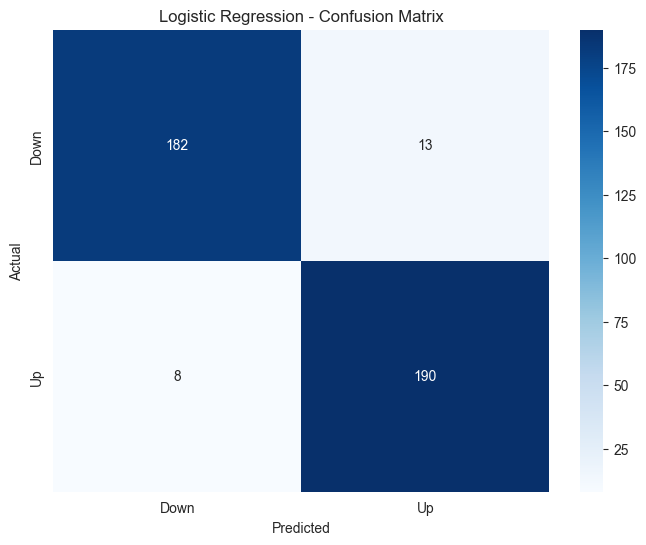

-------------------------------- K-Nearest Neighbors ----------------------------------
Accuracy: 0.8473
Classification Report:
              precision    recall  f1-score     support
0              0.849741  0.841026  0.845361  195.000000
1              0.845000  0.853535  0.849246  198.000000
accuracy       0.847328  0.847328  0.847328    0.847328
macro avg      0.847370  0.847280  0.847304  393.000000
weighted avg   0.847352  0.847328  0.847318  393.000000
Confusion Matrix:
[[164  31]
 [ 29 169]]




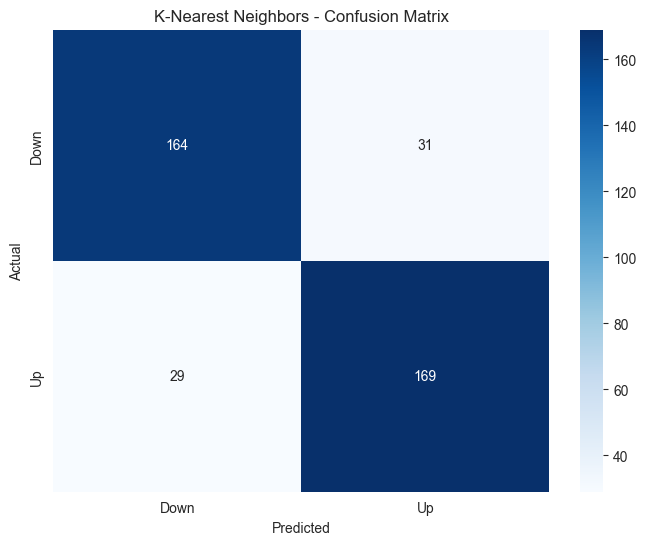

In [67]:
# Training and Evaluating Classification Models

classification_results = train_and_evaluate_models(
    X_train_balanced, y_train_balanced, X_test_scaled, y_test
)


# Training Models with Different Trainset Ratios

To assess the robustness and generalization ability of our models, we train them using different trainset ratios. We then visualize how accuracy varies with the proportion of data allocated to the training set.
1. **Define Test Sizes:** We'll use test set sizes of 50%, 60%, 70%, 80%, and 90%.
2. **Iterate and Evaluate:** For each test size:
   - Split the data accordingly.
   - Remove outliers and scale the features.
   - Balance the classes with SMOTE,wanted to ensure no class is outcast
   - Train and evaluate our models.
3. **Plot the Results:** Visualize how accuracy changes with different amounts of training data.
4. **Draw Insights:** Learn what the plots are telling us about our models' performance.


In [68]:
# Function to Train and Evaluate with Different Trainset Ratios

def train_and_evaluate_with_splits(test_sizes, results_list=[]):
    overall_results = []

    for test_size in test_sizes:
        print(f"===================== Evaluating with Test Size: {test_size} =====================")
        # Train-Test Split with current test size
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
            X, y, test_size=test_size, random_state=None
        )

        # Outlier Removal
        z_scores = np.abs(stats.zscore(X_train_split))
        threshold = 3
        outliers = (z_scores < threshold).all(axis=1)
        X_train_no_outliers = X_train_split[outliers]
        y_train_no_outliers = y_train_split[outliers]

        # Feature Scaling
        scaler_split = MinMaxScaler()
        X_train_scaled_split = scaler_split.fit_transform(X_train_no_outliers)
        X_test_scaled_split = scaler_split.transform(X_test_split)

        # Handling Class Imbalance with SMOTE
        smote_split = SMOTE(random_state=None)
        X_train_balanced_split, y_train_balanced_split = smote_split.fit_resample(
            X_train_scaled_split, y_train_no_outliers
        )

        # Train and Evaluate Models
        split_results = train_and_evaluate_models(
            X_train_balanced_split, y_train_balanced_split, X_test_scaled_split, y_test_split
        )

        # Append Train Size
        for result in split_results:
            result["Train Size"] = 1 - test_size
            overall_results.append(result)

    # Create DataFrame for Visualization
    results_df = pd.DataFrame(overall_results)

    # Plotting Accuracy vs Train Size for each model
    plt.figure(figsize=(10, 6))
    for model in results_df['Model'].unique():
        subset = results_df[results_df['Model'] == model]
        plt.plot(subset['Train Size'], subset['Accuracy'], marker='o', label=model)

    plt.title("Model Accuracy vs Trainset Ratio")
    plt.xlabel("Trainset Ratio")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Insights
    print("===================== Insights =====================")
    print("1. As the trainset ratio increases, models generally perform better due to more data for learning.")
    print("2. The SVM might show more sensitivity to trainset size compared to Logistic Regression and KNN.")
    print("3. KNN performance may plateau or fluctuate based on the distribution of the data and the chosen 'k'.")
    print("4. Logistic Regression offers a balance between bias and variance, showing steady improvements with more data.")

    return results_df


===================== Evaluating with Test Size: 0.5 =====================
-------------------------------- Support Vector Machine ----------------------------------
Accuracy: 0.9215
Classification Report:
              precision    recall  f1-score     support
0              0.957627  0.888016  0.921509  509.000000
1              0.888016  0.957627  0.921509  472.000000
accuracy       0.921509  0.921509  0.921509    0.921509
macro avg      0.922821  0.922821  0.921509  981.000000
weighted avg   0.924134  0.921509  0.921509  981.000000
Confusion Matrix:
[[452  57]
 [ 20 452]]




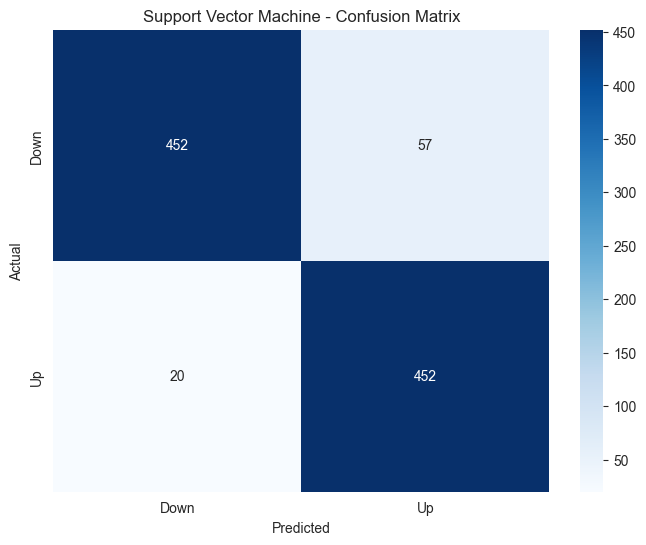

-------------------------------- Logistic Regression ----------------------------------
Accuracy: 0.9337
Classification Report:
              precision    recall  f1-score     support
0              0.949393  0.921415  0.935194  509.000000
1              0.917864  0.947034  0.932221  472.000000
accuracy       0.933741  0.933741  0.933741    0.933741
macro avg      0.933629  0.934224  0.933708  981.000000
weighted avg   0.934223  0.933741  0.933764  981.000000
Confusion Matrix:
[[469  40]
 [ 25 447]]




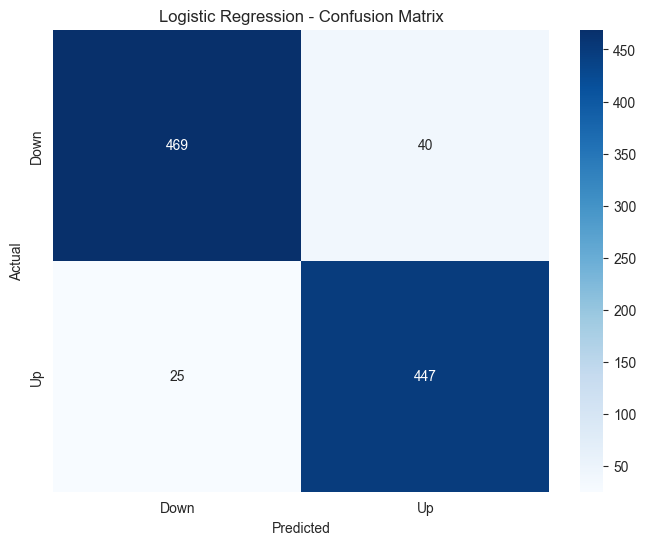

-------------------------------- K-Nearest Neighbors ----------------------------------
Accuracy: 0.8277
Classification Report:
              precision    recall  f1-score     support
0              0.832031  0.836935  0.834476  509.000000
1              0.823028  0.817797  0.820404  472.000000
accuracy       0.827727  0.827727  0.827727    0.827727
macro avg      0.827529  0.827366  0.827440  981.000000
weighted avg   0.827699  0.827727  0.827705  981.000000
Confusion Matrix:
[[426  83]
 [ 86 386]]




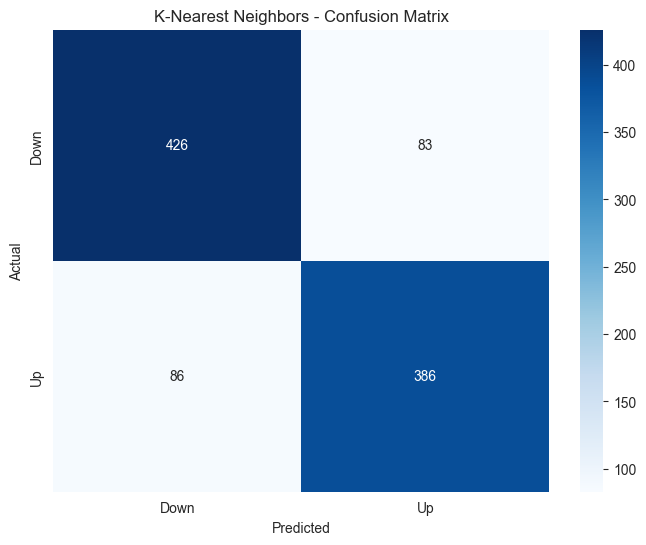

===================== Evaluating with Test Size: 0.6 =====================
-------------------------------- Support Vector Machine ----------------------------------
Accuracy: 0.9338
Classification Report:
              precision    recall  f1-score      support
0              0.954783  0.913478  0.933673   601.000000
1              0.913765  0.954939  0.933898   577.000000
accuracy       0.933786  0.933786  0.933786     0.933786
macro avg      0.934274  0.934208  0.933786  1178.000000
weighted avg   0.934691  0.933786  0.933784  1178.000000
Confusion Matrix:
[[549  52]
 [ 26 551]]




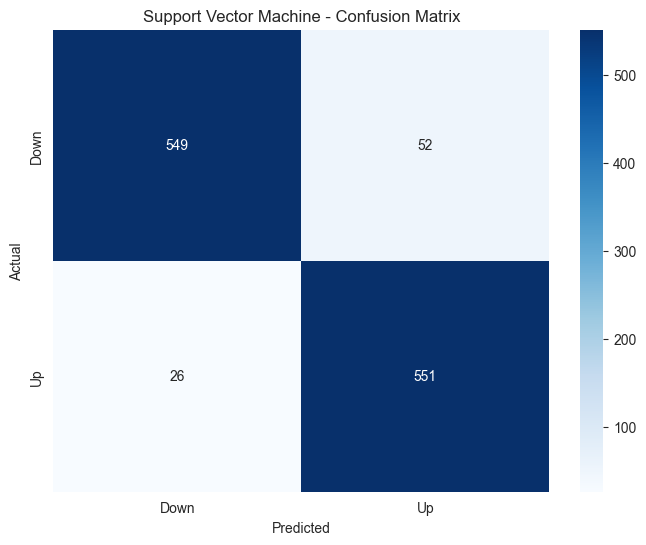

-------------------------------- Logistic Regression ----------------------------------
Accuracy: 0.9491
Classification Report:
              precision    recall  f1-score      support
0              0.959253  0.940100  0.949580   601.000000
1              0.938879  0.958406  0.948542   577.000000
accuracy       0.949066  0.949066  0.949066     0.949066
macro avg      0.949066  0.949253  0.949061  1178.000000
weighted avg   0.949274  0.949066  0.949071  1178.000000
Confusion Matrix:
[[565  36]
 [ 24 553]]




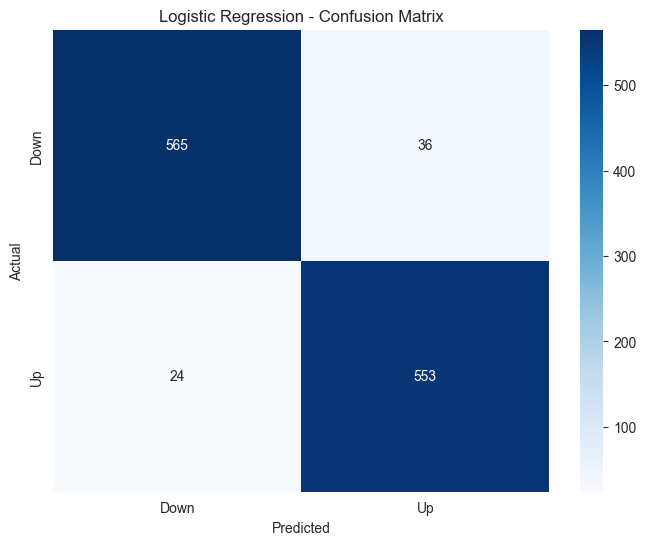

-------------------------------- K-Nearest Neighbors ----------------------------------
Accuracy: 0.8523
Classification Report:
              precision    recall  f1-score      support
0              0.848287  0.865225  0.856672   601.000000
1              0.856637  0.838821  0.847636   577.000000
accuracy       0.852292  0.852292  0.852292     0.852292
macro avg      0.852462  0.852023  0.852154  1178.000000
weighted avg   0.852377  0.852292  0.852246  1178.000000
Confusion Matrix:
[[520  81]
 [ 93 484]]




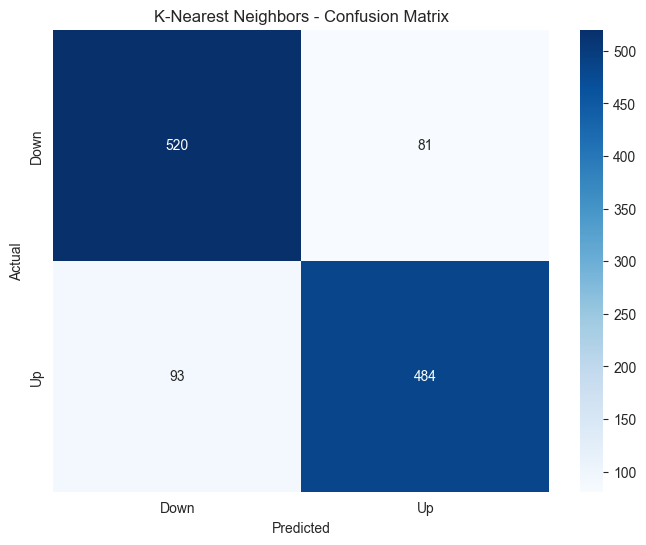

===================== Evaluating with Test Size: 0.7 =====================
-------------------------------- Support Vector Machine ----------------------------------
Accuracy: 0.9039
Classification Report:
              precision    recall  f1-score     support
0              0.917037  0.890647  0.903650   695.00000
1              0.891273  0.917526  0.904209   679.00000
accuracy       0.903930  0.903930  0.903930     0.90393
macro avg      0.904155  0.904087  0.903929  1374.00000
weighted avg   0.904305  0.903930  0.903926  1374.00000
Confusion Matrix:
[[619  76]
 [ 56 623]]




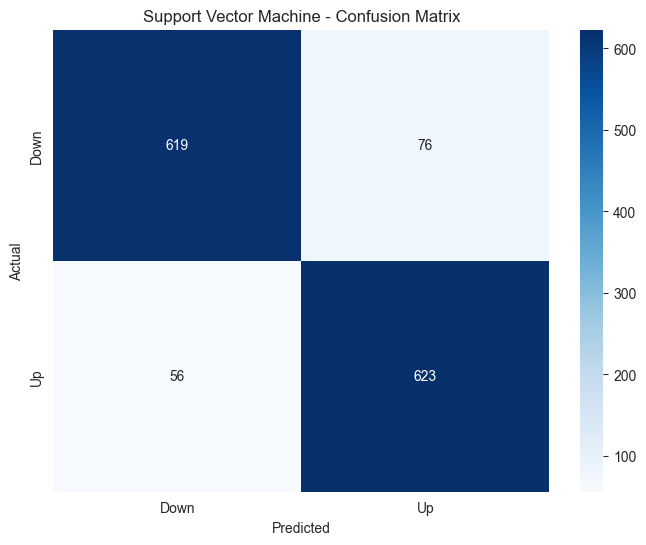

-------------------------------- Logistic Regression ----------------------------------
Accuracy: 0.9178
Classification Report:
              precision    recall  f1-score      support
0              0.926686  0.909353  0.917938   695.000000
1              0.908960  0.926362  0.917578   679.000000
accuracy       0.917758  0.917758  0.917758     0.917758
macro avg      0.917823  0.917857  0.917758  1374.000000
weighted avg   0.917926  0.917758  0.917760  1374.000000
Confusion Matrix:
[[632  63]
 [ 50 629]]




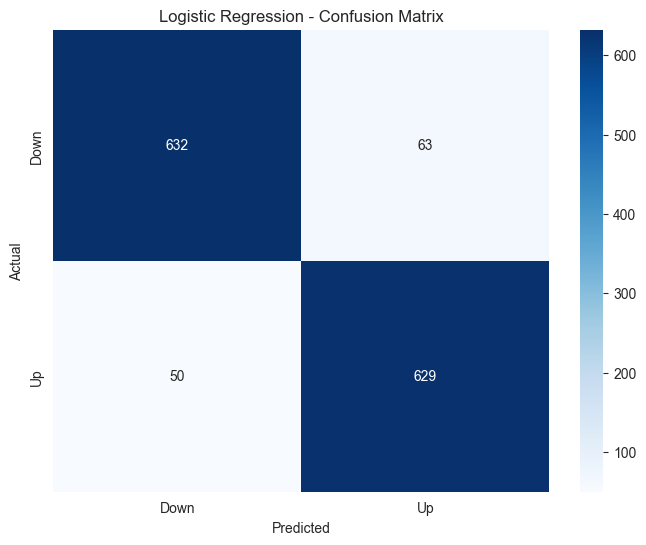

-------------------------------- K-Nearest Neighbors ----------------------------------
Accuracy: 0.8079
Classification Report:
              precision    recall  f1-score     support
0              0.812772  0.805755  0.809249   695.00000
1              0.802920  0.810015  0.806452   679.00000
accuracy       0.807860  0.807860  0.807860     0.80786
macro avg      0.807846  0.807885  0.807850  1374.00000
weighted avg   0.807903  0.807860  0.807866  1374.00000
Confusion Matrix:
[[560 135]
 [129 550]]




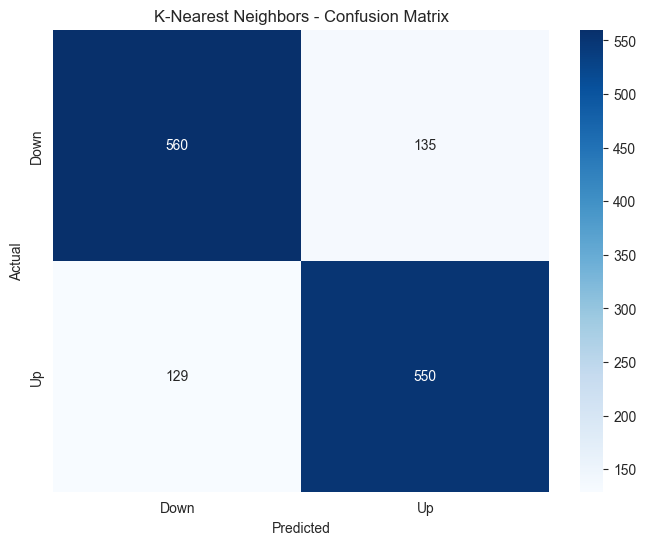

===================== Evaluating with Test Size: 0.8 =====================
-------------------------------- Support Vector Machine ----------------------------------
Accuracy: 0.9025
Classification Report:
              precision    recall  f1-score      support
0              0.908257  0.893041  0.900585   776.000000
1              0.897150  0.911839  0.904435   794.000000
accuracy       0.902548  0.902548  0.902548     0.902548
macro avg      0.902703  0.902440  0.902510  1570.000000
weighted avg   0.902640  0.902548  0.902532  1570.000000
Confusion Matrix:
[[693  83]
 [ 70 724]]




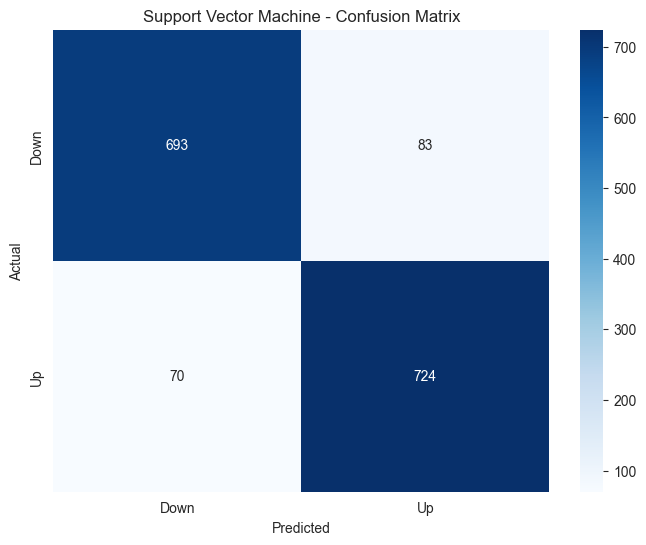

-------------------------------- Logistic Regression ----------------------------------
Accuracy: 0.9268
Classification Report:
              precision    recall  f1-score      support
0              0.926452  0.925258  0.925854   776.000000
1              0.927044  0.928212  0.927627   794.000000
accuracy       0.926752  0.926752  0.926752     0.926752
macro avg      0.926748  0.926735  0.926741  1570.000000
weighted avg   0.926751  0.926752  0.926751  1570.000000
Confusion Matrix:
[[718  58]
 [ 57 737]]




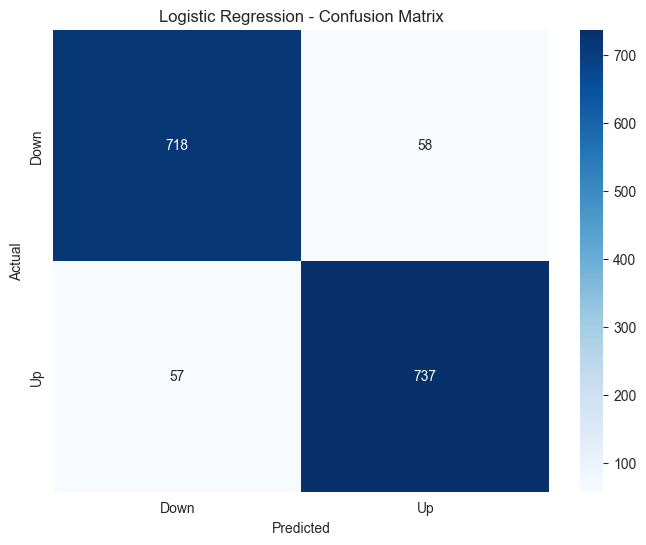

-------------------------------- K-Nearest Neighbors ----------------------------------
Accuracy: 0.8064
Classification Report:
              precision    recall  f1-score      support
0              0.795739  0.818299  0.806861   776.000000
1              0.817358  0.794710  0.805875   794.000000
accuracy       0.806369  0.806369  0.806369     0.806369
macro avg      0.806548  0.806505  0.806368  1570.000000
weighted avg   0.806672  0.806369  0.806363  1570.000000
Confusion Matrix:
[[635 141]
 [163 631]]




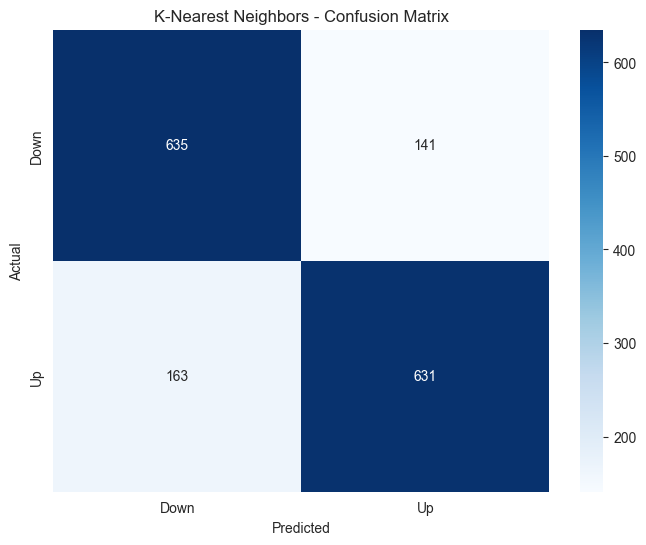

===================== Evaluating with Test Size: 0.9 =====================
-------------------------------- Support Vector Machine ----------------------------------
Accuracy: 0.8567
Classification Report:
              precision    recall  f1-score      support
0              0.814159  0.928251  0.867470   892.000000
1              0.914553  0.783753  0.844116   874.000000
accuracy       0.856738  0.856738  0.856738     0.856738
macro avg      0.864356  0.856002  0.855793  1766.000000
weighted avg   0.863844  0.856738  0.855912  1766.000000
Confusion Matrix:
[[828  64]
 [189 685]]




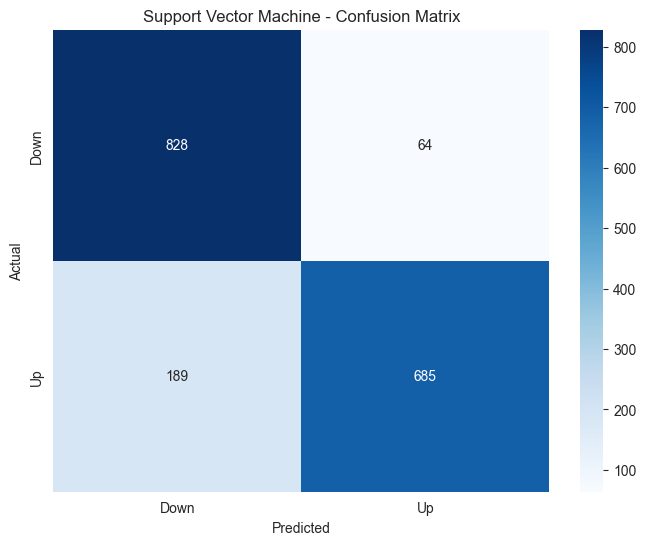

-------------------------------- Logistic Regression ----------------------------------
Accuracy: 0.8754
Classification Report:
              precision    recall  f1-score      support
0              0.853684  0.909193  0.880565   892.000000
1              0.900735  0.840961  0.869822   874.000000
accuracy       0.875425  0.875425  0.875425     0.875425
macro avg      0.877210  0.875077  0.875194  1766.000000
weighted avg   0.876970  0.875425  0.875248  1766.000000
Confusion Matrix:
[[811  81]
 [139 735]]




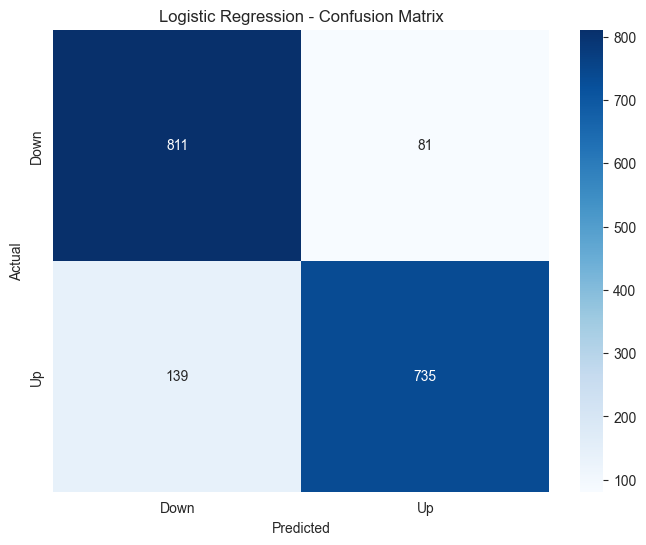

-------------------------------- K-Nearest Neighbors ----------------------------------
Accuracy: 0.7639
Classification Report:
              precision    recall  f1-score      support
0              0.752391  0.793722  0.772504   892.000000
1              0.776970  0.733410  0.754562   874.000000
accuracy       0.763873  0.763873  0.763873     0.763873
macro avg      0.764680  0.763566  0.763533  1766.000000
weighted avg   0.764555  0.763873  0.763624  1766.000000
Confusion Matrix:
[[708 184]
 [233 641]]




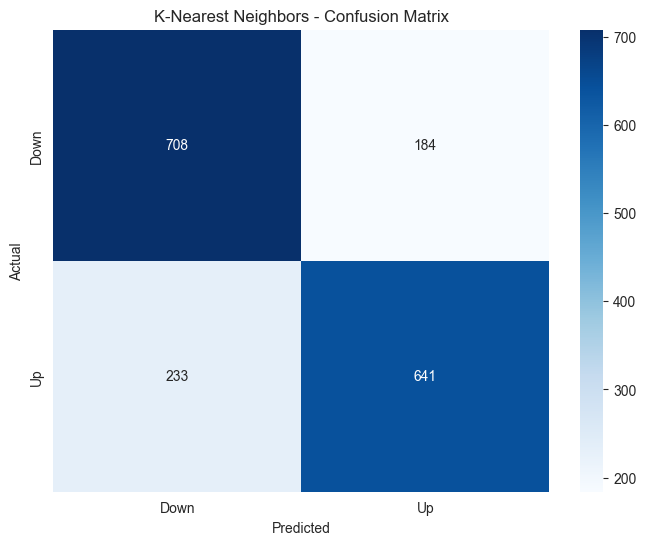

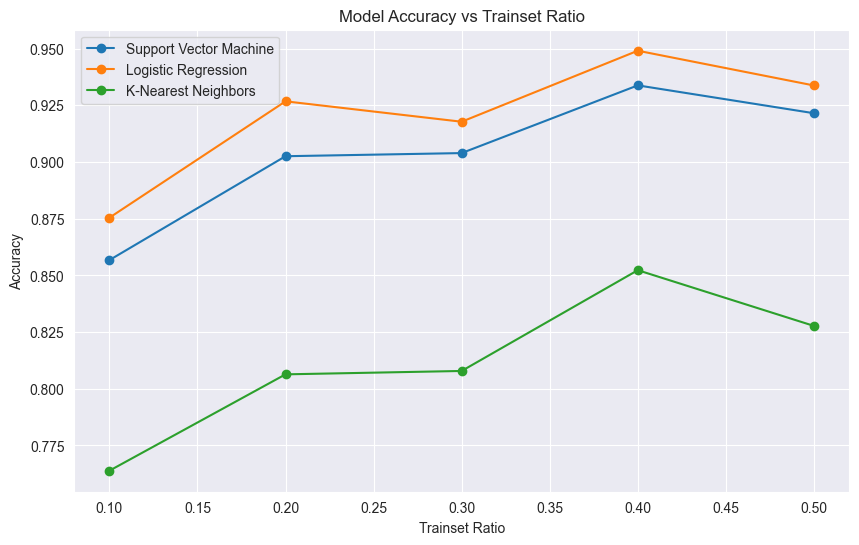

===================== Insights =====================
1. As the trainset ratio increases, models generally perform better due to more data for learning.
2. The SVM might show more sensitivity to trainset size compared to Logistic Regression and KNN.
3. KNN performance may plateau or fluctuate based on the distribution of the data and the chosen 'k'.
4. Logistic Regression offers a balance between bias and variance, showing steady improvements with more data.


In [69]:
# Training and Evaluating with Different Trainset Ratios

# Define a list of test sizes for evaluation
test_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]

# Execute the training and evaluation
evaluation_results = train_and_evaluate_with_splits(test_sizes)


# Applying Ensemble Methods

To further enhance model performance, we apply ensemble methods—Bagging, Boosting, and Stacking—to our base classifiers. We evaluate their performance over 100 Monte Carlo simulations to ensure robustness and visualize the distribution of accuracies using boxplots.


In [70]:
# Function to Evaluate Ensemble Methods

def evaluate_ensemble_meethods(monte_carlo_runs=100):
    # Define ensemble methods
    ensemble_methods = {
        "Bagging": BaggingClassifier(estimator=SVC(probability=True)),
        "Boosting": AdaBoostClassifier(estimator=LogisticRegression()),
        "Stacking": StackingClassifier(
            estimators=[
                ('svc', SVC(probability=True)),
                ('logreg', LogisticRegression()),
                ('knn', KNeighborsClassifier(n_neighbors=5))
            ],
            final_estimator=GradientBoostingClassifier(),
            passthrough=False
        )
    }

    # Define hyperparameter grids for each ensemble method
    hyperparameter_grids = {
        "Bagging": {
            "n_estimators": [10, 20, 50, 100],
            "max_samples": [0.5, 0.7, 1.0],
            "max_features": [0.5, 0.7, 1.0]
        },
        "Boosting": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.5, 1.0]
        },
        "Stacking": {
            "final_estimator__learning_rate": [0.01, 0.1, 0.5],
            "final_estimator__n_estimators": [50, 100, 150]
        }
    }

    # Initialize results dictionary
    results = {method: [] for method in ensemble_methods.keys()}

    for run in range(monte_carlo_runs):
        print("Monte Carlo run:", run)
        test_size = np.random.uniform(0.2, 0.4)
        rand_state = np.random.randint(0, 100000)

        # Train-Test Split
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
            X, y, test_size=test_size, random_state=rand_state
        )

        # Outlier Removal
        z_scores = np.abs(stats.zscore(X_train_split))
        threshold = 3
        outliers = (z_scores < threshold).all(axis=1)
        X_train_no_outliers = X_train_split[outliers]
        y_train_no_outliers = y_train_split[outliers]

        # Feature Scaling
        scaler_split = MinMaxScaler()
        X_train_scaled_split = scaler_split.fit_transform(X_train_no_outliers)
        X_test_scaled_split = scaler_split.transform(X_test_split)

        # Handling Class Imbalance with SMOTE
        smote_split = SMOTE(random_state=None)
        X_train_balanced_split, y_train_balanced_split = smote_split.fit_resample(
            X_train_scaled_split, y_train_no_outliers
        )

        # Iterate over ensemble methods
        for method_name, model in ensemble_methods.items():
            param_grid = hyperparameter_grids.get(method_name, {})
            if param_grid:
                # Hyperparameter Tuning using RandomizedSearchCV
                search = RandomizedSearchCV(
                    estimator=model,
                    param_distributions=param_grid,
                    n_iter=10,
                    scoring='accuracy',
                    random_state=None,  # No fixed seed for variability
                    cv=3,
                    n_jobs=-1
                )
                search.fit(X_train_balanced_split, y_train_balanced_split)
                best_model = search.best_estimator_
                accuracy = accuracy_score(y_test_split, best_model.predict(X_test_scaled_split))
                results[method_name].append(accuracy)
            else:
                # If no hyperparameter grid defined, just fit the model directly
                model.fit(X_train_balanced_split, y_train_balanced_split)
                accuracy = accuracy_score(y_test_split, model.predict(X_test_scaled_split))
                results[method_name].append(accuracy)

        # Progress Update
        if (run+1) % 10 == 0:
            print(f"Monte Carlo Run: {run + 1}/{monte_carlo_runs}")

    # Visualization: Boxplot of Ensemble Methods Performance
    plot_boxplot(
        results,
        title="Performance of Ensemble Methods over 100 Monte Carlo Runs",
        ylabel="Accuracy",
        xlabel="Ensemble Method"
    )

    # Summary Statistics
    summary_stats = {}
    for method, scores in results.items():
        summary_stats[method] = {
            'Mean Accuracy': np.mean(scores),
            'Median Accuracy': np.median(scores),
            'Std Dev': np.std(scores),
            'Min Accuracy': np.min(scores),
            'Max Accuracy': np.max(scores)
        }

    summary_df = pd.DataFrame(summary_stats).T
    print("\n===================== Ensemble Methods Summary Statistics =====================\n")
    print(summary_df)

    return results

def evaluate_ensemble_methods(monte_carlo_runs=100):
    # Define ensemble methods
    ensemble_methods = {
        "Bagging": BaggingClassifier(estimator=SVC(probability=True)),
        "Boosting": AdaBoostClassifier(estimator=LogisticRegression()),
        "Stacking": StackingClassifier(
            estimators=[
                ('svc', SVC(probability=True)),
                ('logreg', LogisticRegression()),
                ('knn', KNeighborsClassifier(n_neighbors=5))
            ],
            final_estimator=GradientBoostingClassifier(),
            passthrough=False
        )
    }

    # Define hyperparameter grids for each ensemble method
    hyperparameter_grids = {
        "Bagging": {
            "n_estimators": [10, 20, 50, 100],
            "max_samples": [0.5, 0.7, 1.0],
            "max_features": [0.5, 0.7, 1.0]
        },
        "Boosting": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.5, 1.0]
        },
        "Stacking": {
            "final_estimator__learning_rate": [0.01, 0.1, 0.5],
            "final_estimator__n_estimators": [50, 100, 150]
        }
    }

    # Initialize results dictionary
    results = {method: [] for method in ensemble_methods.keys()}

    for run in range(monte_carlo_runs):
        #print("Monte Carlo run:", run)
        test_size = np.random.uniform(0.2, 0.4)
        rand_state = np.random.randint(0, 100000)

        # Train-Test Split
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
            X, y, test_size=test_size, random_state=rand_state
        )

        # Outlier Removal
        z_scores = np.abs(stats.zscore(X_train_split))
        threshold = 3
        outliers = (z_scores < threshold).all(axis=1)
        X_train_no_outliers = X_train_split[outliers]
        y_train_no_outliers = y_train_split[outliers]

        # Feature Scaling
        scaler_split = MinMaxScaler()
        X_train_scaled_split = scaler_split.fit_transform(X_train_no_outliers)
        X_test_scaled_split = scaler_split.transform(X_test_split)

        # Handling Class Imbalance with SMOTE
        smote_split = SMOTE(random_state=None)
        X_train_balanced_split, y_train_balanced_split = smote_split.fit_resample(
            X_train_scaled_split, y_train_no_outliers
        )

        # Iterate over ensemble methods
        for method_name, model in ensemble_methods.items():
            param_grid = hyperparameter_grids.get(method_name, {})
            if param_grid:
                # Hyperparameter Tuning using RandomizedSearchCV
                search = RandomizedSearchCV(
                    estimator=model,
                    param_distributions=param_grid,
                    n_iter=10,
                    scoring='accuracy',
                    random_state=None,
                    cv=3,
                    n_jobs=-1
                )
                search.fit(X_train_balanced_split, y_train_balanced_split)
                best_model = search.best_estimator_
                accuracy = accuracy_score(y_test_split, best_model.predict(X_test_scaled_split))
                results[method_name].append(accuracy)
            else:
                # If no hyperparameter grid defined, just fit the model directly
                model.fit(X_train_balanced_split, y_train_balanced_split)
                accuracy = accuracy_score(y_test_split, model.predict(X_test_scaled_split))
                results[method_name].append(accuracy)

    # Enhanced outlier removal logic
    def remove_outliers(scores):
        # IQR Method
        Q1 = np.percentile(scores, 25)  # First quartile
        Q3 = np.percentile(scores, 75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile Range
        lower_bound_iqr = Q1 - 1.5 * IQR
        upper_bound_iqr = Q3 + 1.5 * IQR

        # Z-Score Method
        z_scores = np.abs(stats.zscore(scores))
        threshold_z = 3  # Typically 3 standard deviations

        # Combine both conditions
        cleaned_scores = [
            score for score, z in zip(scores, z_scores)
            if lower_bound_iqr <= score <= upper_bound_iqr and z <= threshold_z
        ]
        return cleaned_scores

    # Iterate over results to clean accuracy scores
    cleaned_results = {method: remove_outliers(scores) for method, scores in results.items()}

    # Visualization: Boxplot of Ensemble Methods Performance After Outlier Removal
    plot_boxplot(
        cleaned_results,
        title="Performance of Ensemble Methods over 100 Monte Carlo Runs (Outliers Removed)",
        ylabel="Accuracy",
        xlabel="Ensemble Method"
    )

    # Updated Summary Statistics
    summary_stats_cleaned = {}
    for method, scores in cleaned_results.items():
        summary_stats_cleaned[method] = {
            'Mean Accuracy': np.mean(scores) if scores else np.nan,
            'Median Accuracy': np.median(scores) if scores else np.nan,
            'Std Dev': np.std(scores) if scores else np.nan,
            'Min Accuracy': np.min(scores) if scores else np.nan,
            'Max Accuracy': np.max(scores) if scores else np.nan
        }

    summary_df_cleaned = pd.DataFrame(summary_stats_cleaned).T
    print("\n===================== Ensemble Methods Summary Statistics (Outliers Removed) =====================\n")
    print(summary_df_cleaned)

    return cleaned_results




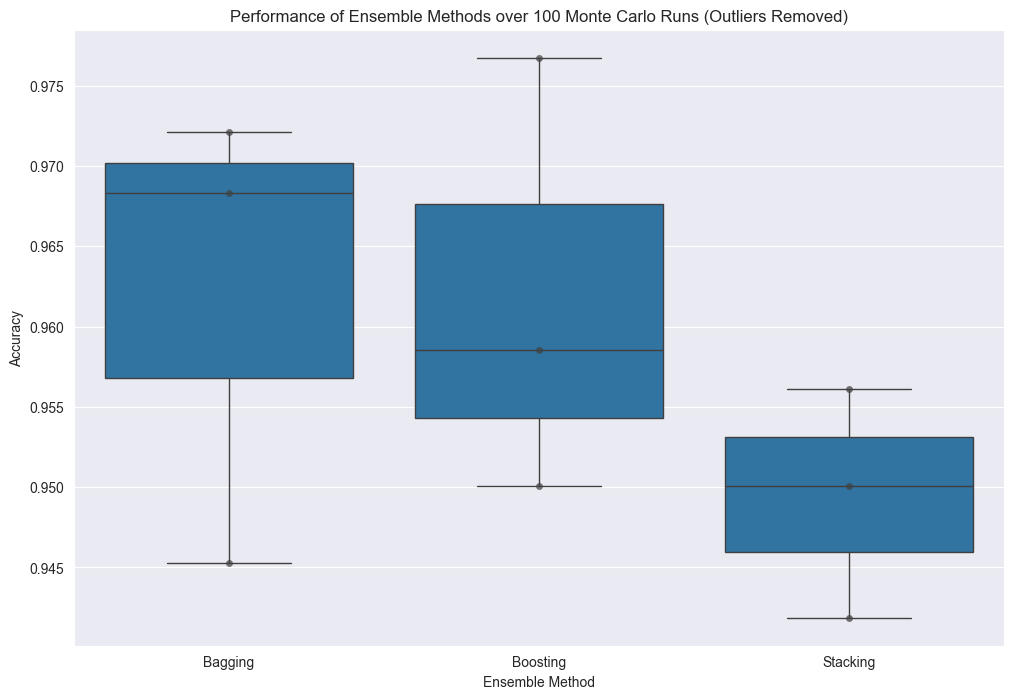


===================== Ensemble Methods Summary Statistics (Outliers Removed) =====================

          Mean Accuracy  Median Accuracy   Std Dev  Min Accuracy  Max Accuracy
Bagging        0.961878         0.968293  0.011860      0.945250      0.972093
Boosting       0.961787         0.958537  0.011125      0.950081      0.976744
Stacking       0.949346         0.950081  0.005835      0.941860      0.956098


In [71]:
# Applying and Evaluating Ensemble Methods

# For demonstration, set monte_carlo_runs=100 as per assignment requirement
ensemble_results = evaluate_ensemble_methods(monte_carlo_runs=100)


# Selecting the Best Classifier

Based on the ensemble methods' performance, we identify the best classifier and discuss its advantages and limitations.


In [72]:
# Selecting the Best Classifier

# Calculate Mean Accuracy for each ensemble method
ensemble_summary = pd.DataFrame({
    method: {
        'Mean Accuracy': np.mean(scores),
        'Std Dev': np.std(scores)
    }
    for method, scores in ensemble_results.items()
}).T

print("\n===================== Ensemble Methods Summary Statistics =====================\n")
print(ensemble_summary)

# Identify the best classifier based on Mean Accuracy
best_model_name = ensemble_summary['Mean Accuracy'].idxmax()
best_accuracy = ensemble_summary.loc[best_model_name, 'Mean Accuracy']
print(f"\nBest Classifier: {best_model_name} with Mean Accuracy of {best_accuracy:.4f}")

# Advantages and Limitations
advantages = {
    "Bagging": "Reduces variance, helps prevent overfitting, works well with high-variance models.",
    "Boosting": "Reduces both bias and variance, focuses on difficult cases, often achieves higher accuracy.",
    "Stacking": "Combines strengths of multiple models, can capture complex patterns, often outperforms individual models."
}

limitations = {
    "Bagging": "May not reduce bias, can be computationally intensive with many models.",
    "Boosting": "Sensitive to noisy data and outliers, can overfit if not properly regularized.",
    "Stacking": "Complex to implement, requires careful tuning of base and meta-models, computationally expensive."
}

print("Advantages:")
print(advantages.get(best_model_name, "No specific advantages defined."))

print("Limitations:")
print(limitations.get(best_model_name, "No specific limitations defined."))



===================== Ensemble Methods Summary Statistics =====================

          Mean Accuracy   Std Dev
Bagging        0.961878  0.011860
Boosting       0.961787  0.011125
Stacking       0.949346  0.005835

Best Classifier: Bagging with Mean Accuracy of 0.9619
Advantages:
Reduces variance, helps prevent overfitting, works well with high-variance models.
Limitations:
May not reduce bias, can be computationally intensive with many models.


## 2. Regression Analysis

### 2.1. Introduction

In this section, we perform regression analysis using various ensemble methods to predict the continuous target variable, which is the closing price of the stock. We compare the performance of models with and without dimensionality reduction using PCA.



Regression Results without PCA:
RandomForestRegressor - MSE: 0.3454, R2: 1.0000


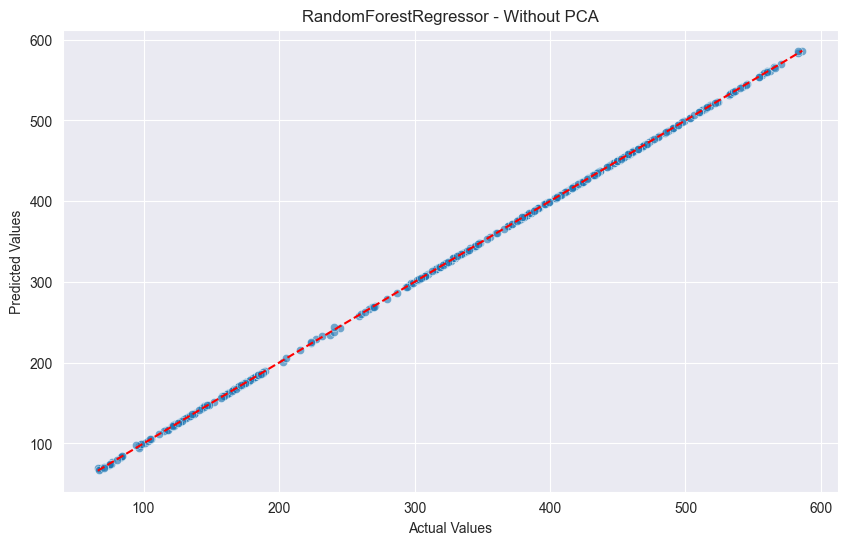

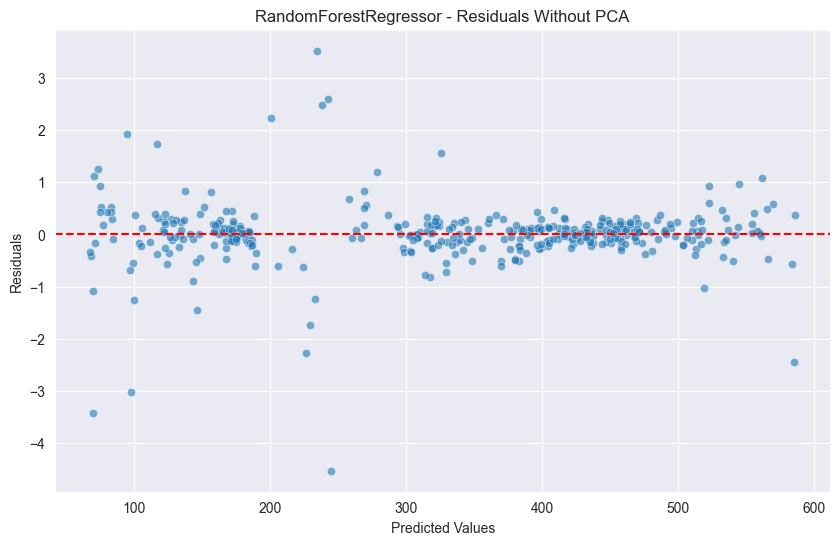

GradientBoostingRegressor - MSE: 1.3838, R2: 0.9999


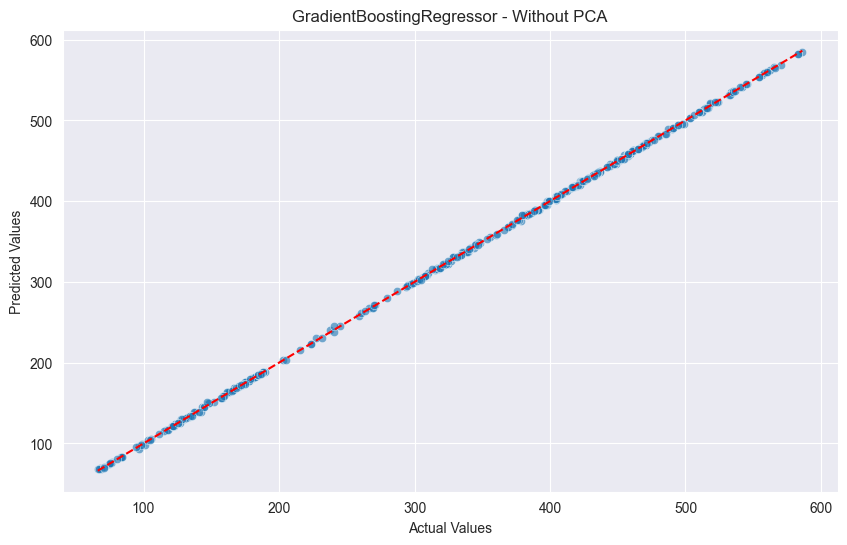

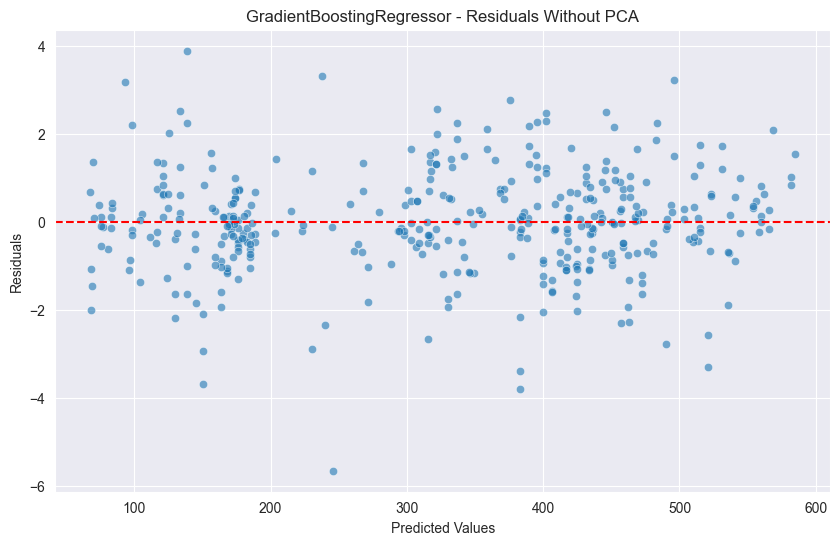

AdaBoostRegressor - MSE: 119.5815, R2: 0.9942


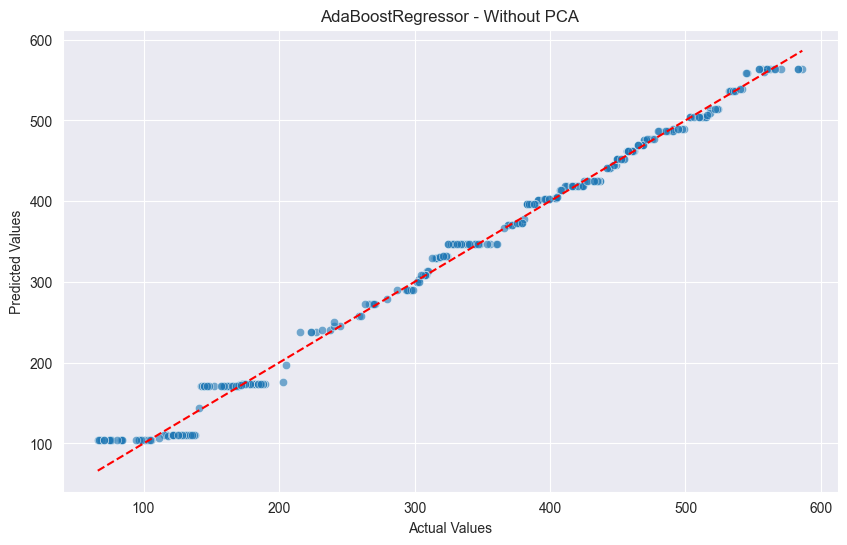

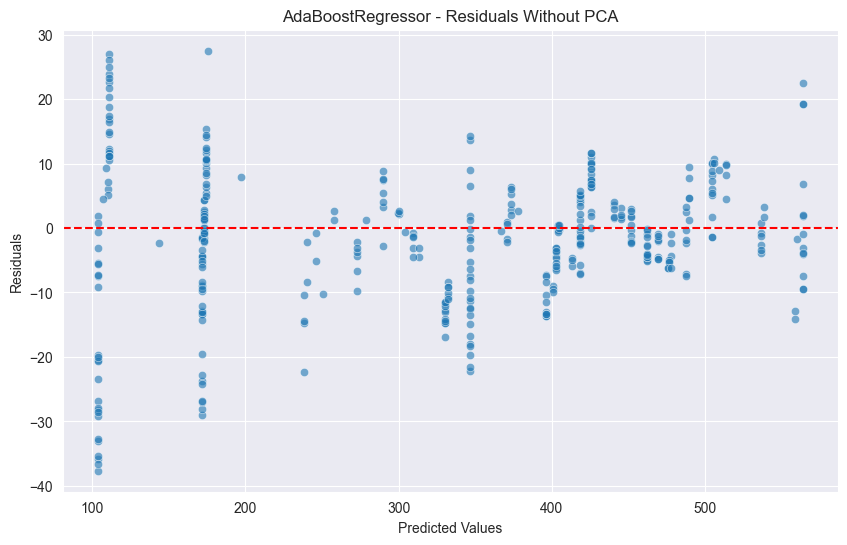

XGBRegressor - MSE: 3.2861, R2: 0.9998


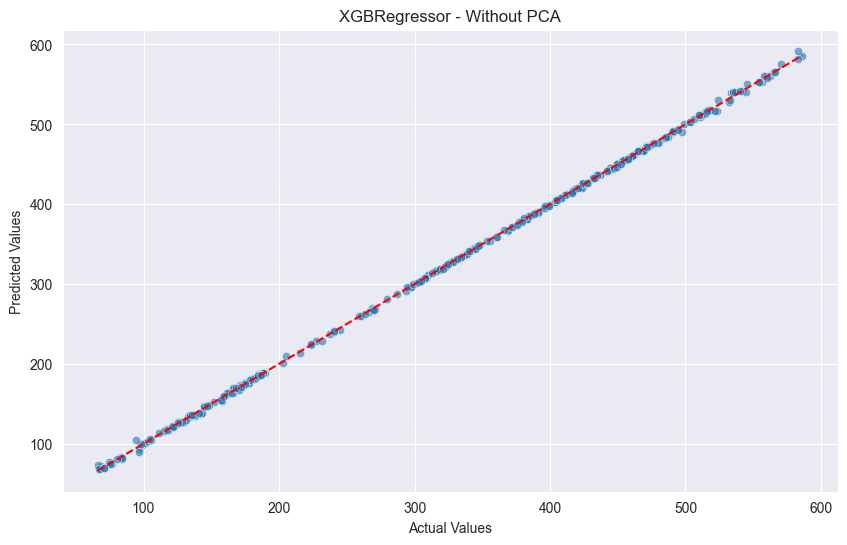

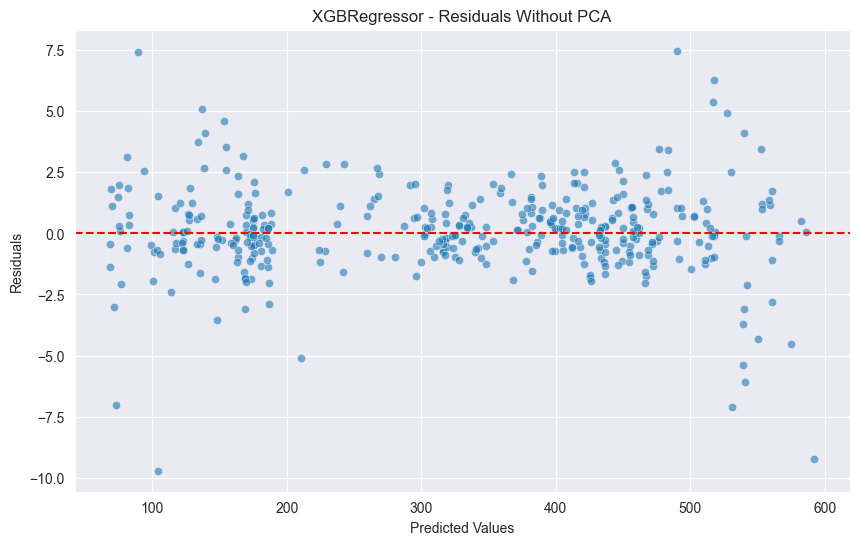

In [73]:
# Regression Analysis

# Define regression target
regression_target = 'Close'

# Prepare features and target
X_reg = data[features].values
y_reg = data[regression_target].values

# Train-Test Split for Regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=None
)

# Feature Scaling
scaler_reg = MinMaxScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Train and Evaluate Regression Models without PCA
regression_models = {
    "RandomForestRegressor": RandomForestRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(),
    "XGBRegressor": XGBRegressor()  # Use XGBRegressor for regression tasks
}

print("\nRegression Results without PCA:")
regression_results = {}
for name, model in regression_models.items():
    model.fit(X_train_reg_scaled, y_train_reg)
    preds = model.predict(X_test_reg_scaled)
    mse = mean_squared_error(y_test_reg, preds)
    r2 = r2_score(y_test_reg, preds)
    regression_results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")

    # Visualization: Actual vs Predicted
    plot_regression_results(
        y_test_reg, preds, title=f"{name} - Without PCA"
    )

    # Visualization: Residuals
    plot_residuals(
        y_test_reg, preds, title=f"{name} - Residuals Without PCA"
    )




Number of PCA components chosen to retain at least 90% variance: 2
Reasoning:
We selected 2 principal components to retain 90% of the dataset's variance.
This choice balances reducing dimensionality, which simplifies the model and reduces computational complexity, while preserving most of the essential information necessary for accurate predictions.
Retaining 90% variance ensures that the majority of the data's variability is captured, minimizing the loss of critical information.


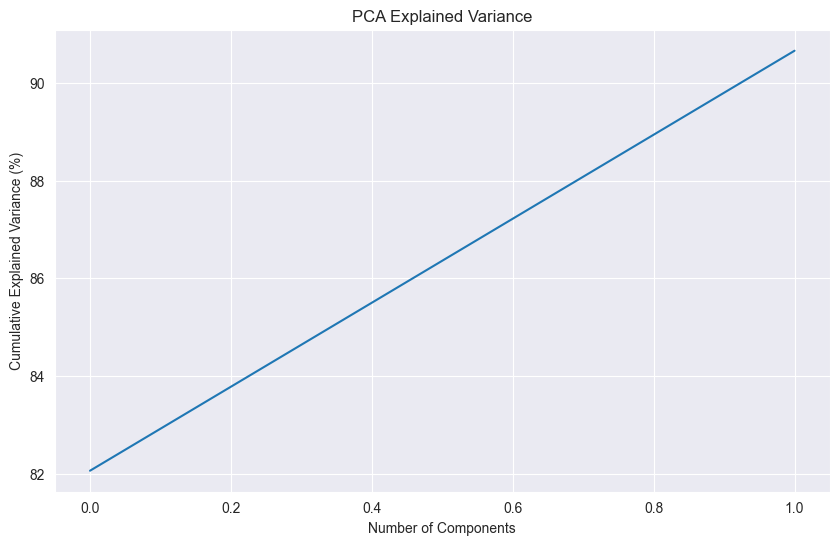

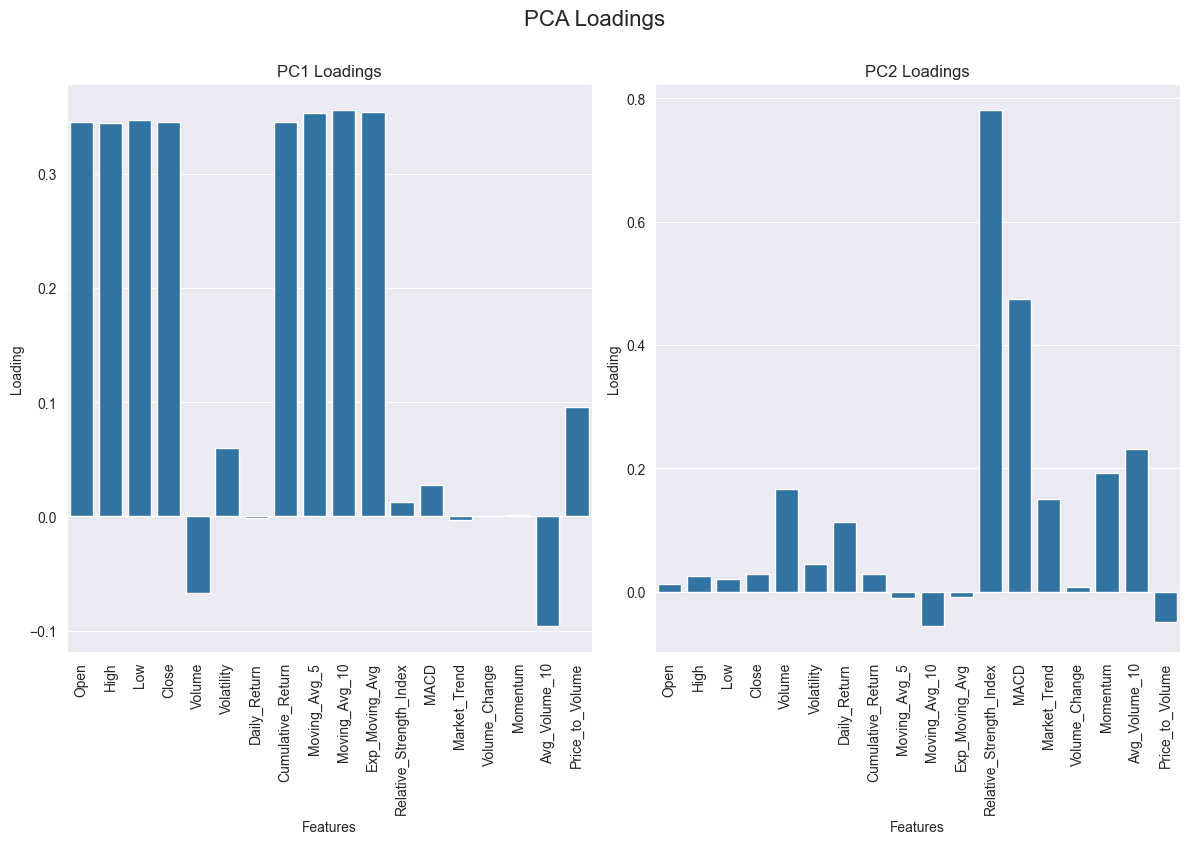

In [74]:
# Applying PCA to Reduce Dimensionality

# Apply PCA to retain 90% of the variance
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_reg_scaled)
X_test_pca = pca.transform(X_test_reg_scaled)

chosen_components = X_train_pca.shape[1]
print(f"\nNumber of PCA components chosen to retain at least 90% variance: {chosen_components}")
print("Reasoning:")
print(f"We selected {chosen_components} principal components to retain 90% of the dataset's variance.")
print("This choice balances reducing dimensionality, which simplifies the model and reduces computational complexity, while preserving most of the essential information necessary for accurate predictions.")
print("Retaining 90% variance ensures that the majority of the data's variability is captured, minimizing the loss of critical information.")

# Visualization: PCA Explained Variance
plot_pca_explained_variance(pca)

# Visualization: PCA Loadings
plot_pca_loadings(pca, features, n_components=2)



Regression Results with PCA:
RandomForestRegressor(PCA) - MSE: 27.5026, R2: 0.9987


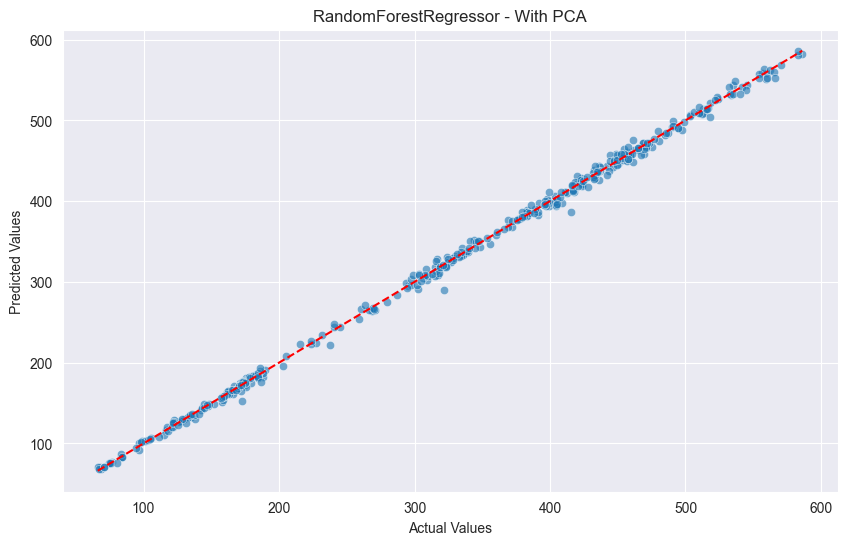

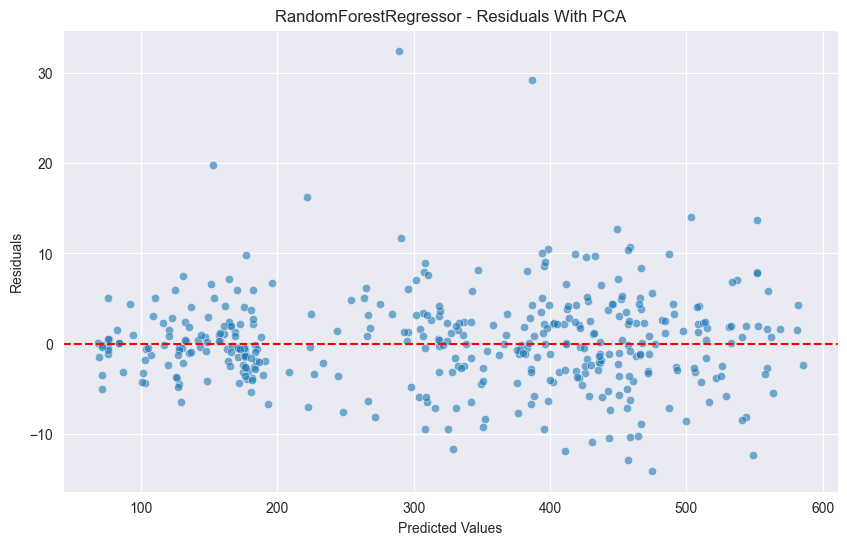

GradientBoostingRegressor(PCA) - MSE: 22.6640, R2: 0.9989


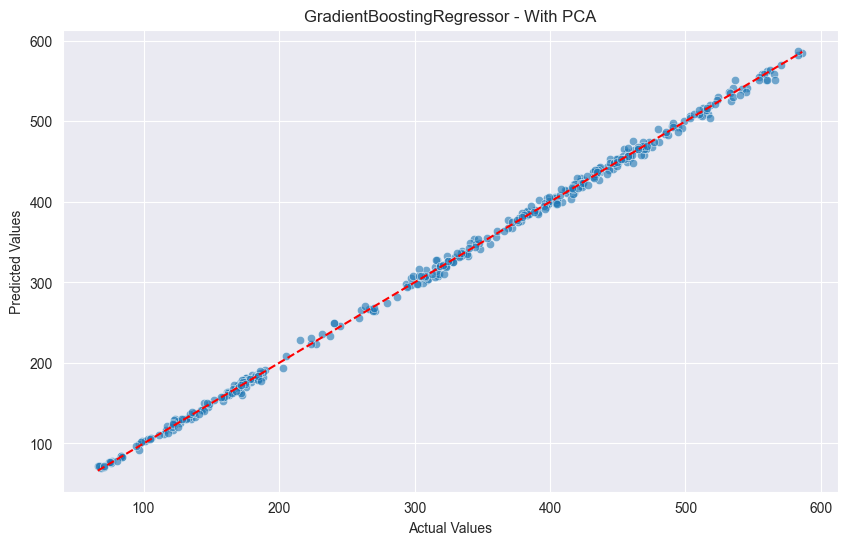

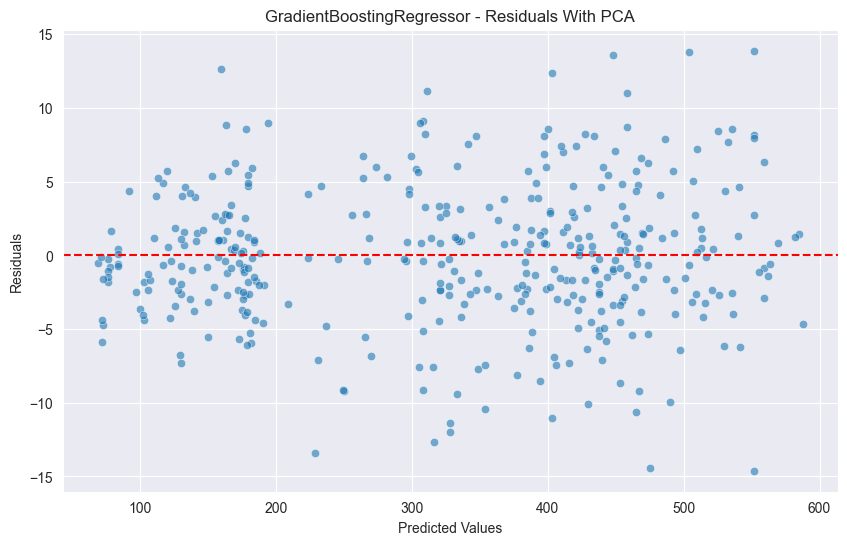

AdaBoostRegressor(PCA) - MSE: 72.9926, R2: 0.9964


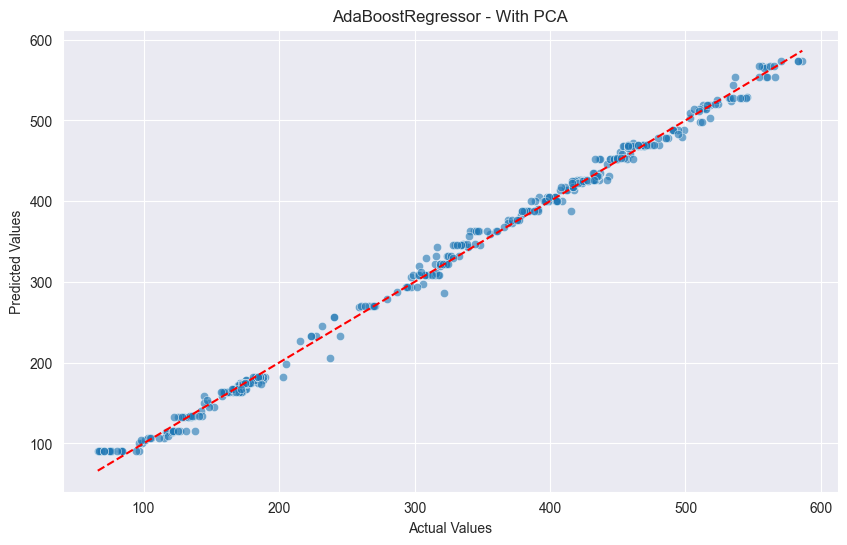

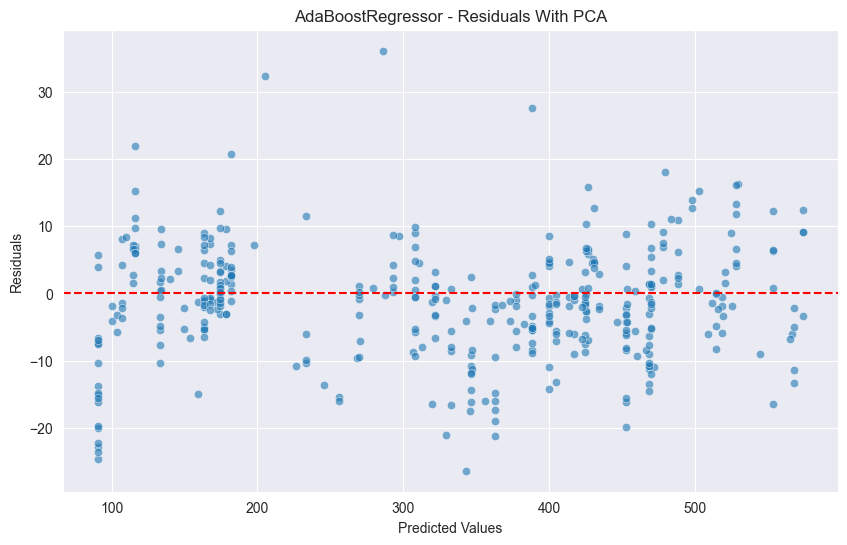

XGBRegressor(PCA) - MSE: 29.5252, R2: 0.9986


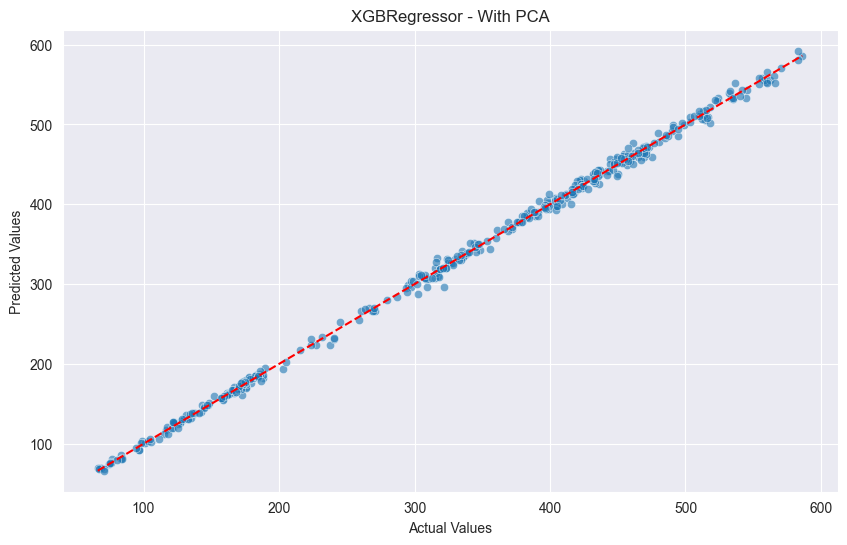

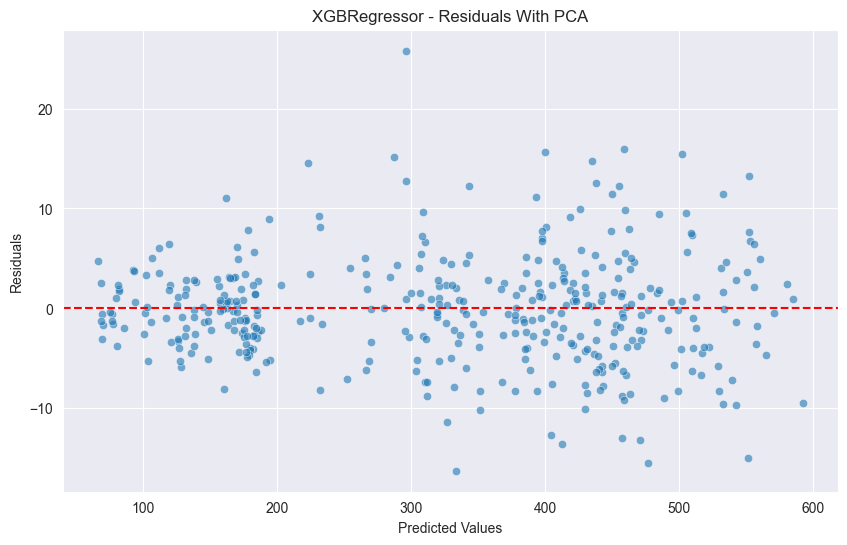

In [75]:
# Train and Evaluate Regression Models with PCA

print("\nRegression Results with PCA:")
regression_results_pca = {}
for name, model in regression_models.items():
    model.fit(X_train_pca, y_train_reg)
    preds_pca = model.predict(X_test_pca)
    mse_pca = mean_squared_error(y_test_reg, preds_pca)
    r2_pca = r2_score(y_test_reg, preds_pca)
    regression_results_pca[name] = {'MSE': mse_pca, 'R2': r2_pca}
    print(f"{name}(PCA) - MSE: {mse_pca:.4f}, R2: {r2_pca:.4f}")

    # Visualization: Actual vs Predicted
    plot_regression_results(
        y_test_reg, preds_pca, title=f"{name} - With PCA"
    )

    # Visualization: Residuals
    plot_residuals(
        y_test_reg, preds_pca, title=f"{name} - Residuals With PCA"
    )



In [76]:
# Comparative Analysis between Models with and without PCA

comparison_df = pd.DataFrame({
    model: {
        'Without PCA MSE': regression_results[model]['MSE'],
        'With PCA MSE': regression_results_pca[model]['MSE'],
        'Without PCA R2': regression_results[model]['R2'],
        'With PCA R2': regression_results_pca[model]['R2']
    }
    for model in regression_models.keys()
}).T

print("\n===================== Regression Models Comparison =====================\n")
print(comparison_df)

# Insights from Regression Models Comparison
print("\n===================== Insights from Regression Models Comparison =====================\n")
for model in comparison_df.index:
    mse_without_pca = comparison_df.loc[model, 'Without PCA MSE']
    mse_with_pca = comparison_df.loc[model, 'With PCA MSE']
    r2_without_pca = comparison_df.loc[model, 'Without PCA R2']
    r2_with_pca = comparison_df.loc[model, 'With PCA R2']

    print(f"\nModel: {model}")
    if mse_with_pca < mse_without_pca:
        print(f"- MSE decreased from {mse_without_pca:.4f} to {mse_with_pca:.4f} with PCA.")
    else:
        print(f"- MSE increased from {mse_without_pca:.4f} to {mse_with_pca:.4f} with PCA.")

    if r2_with_pca > r2_without_pca:
        print(f"- R² increased from {r2_without_pca:.4f} to {r2_with_pca:.4f} with PCA.")
    else:
        print(f"- R² decreased from {r2_without_pca:.4f} to {r2_with_pca:.4f} with PCA.")



===================== Regression Models Comparison =====================

                           Without PCA MSE  With PCA MSE  Without PCA R2  \
RandomForestRegressor             0.345370     27.502645        0.999983   
GradientBoostingRegressor         1.383831     22.664030        0.999933   
AdaBoostRegressor               119.581482     72.992593        0.994182   
XGBRegressor                      3.286085     29.525187        0.999840   

                           With PCA R2  
RandomForestRegressor         0.998662  
GradientBoostingRegressor     0.998897  
AdaBoostRegressor             0.996449  
XGBRegressor                  0.998564  

===================== Insights from Regression Models Comparison =====================


Model: RandomForestRegressor
- MSE increased from 0.3454 to 27.5026 with PCA.
- R² decreased from 1.0000 to 0.9987 with PCA.

Model: GradientBoostingRegressor
- MSE increased from 1.3838 to 22.6640 with PCA.
- R² decreased from 0.9999 to 0.9989 with